<a href="https://colab.research.google.com/github/mberkancetin/Customizable-Structured-Electronic-Brainwriting/blob/main/ColabDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 CSEB Semantic Analysis Suite: From Text to Topological Structure

**Author:** <input type="text" id="author" value="Your Name or Research Group" size="40">

<script>
  document.getElementById("author").addEventListener("input", function() {
    console.log("Author set to:", this.value);
  });
</script>

**Methodology:** Natural Language Processing (NLP) & Unsupervised Machine Learning  

## Overview
This notebook implements a rigorous computational pipeline to analyze qualitative data generated from Customizable Structured Electronic Brainwriting (CSEB) sessions. Unlike traditional qualitative coding which relies solely on human interpretation, this workflow utilizes high-dimensional vector space modeling to validate semantic structures empirically.

## Methodological Framework
1.  **Text Preprocessing:** Lemmatization and domain-specific synonym mapping using `spaCy`.
2.  **Vectorization:** Generating semantic embeddings using Sentence-BERT (`all-MiniLM-L6-v2`) to capture contextual meaning rather than lexical frequency.
3.  **Dimensionality Reduction (UMAP):** Projecting high-dimensional vectors into 2D space to visualize semantic topology (McInnes et al., 2018).
4.  **Structural Validation (K-Means & Centroids):** Comparing machine-generated clusters against human-coded criteria using Silhouette Scores and Cosine Similarity.
5.  **Network Analysis:** Constructing a keyword co-occurrence graph using Louvain Community Detection to identify latent thematic bridges.

## 1. Environment Setup & Library Installation
This cell installs the necessary libraries for NLP, Machine Learning, and Visualization.

In [110]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn
!pip install -q umap-learn sentence-transformers
!pip install -q spacy python-louvain networkx
!pip install -q bertopic setfit datasets
!python -m spacy download en_core_web_sm

import os
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import networkx as nx
import spacy
import torch
from IPython.display import display

import gspread
from google.auth import default
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.service_account import ServiceAccountCredentials

from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score, adjusted_mutual_info_score, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from community import community_louvain
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from setfit import SetFitModel, Trainer
from datasets import Dataset

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ---------------------------------------------------------
# REPRODUCIBILITY CONFIGURATION
# ---------------------------------------------------------
RANDOM_STATE = 42
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(RANDOM_STATE)
print("✅ Libraries installed and environment seeded for reproducibility.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 81.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✅ Libraries installed and environment seeded for reproducibility.


## 2. Data Loading & Configuration
Please paste below the Google Sheet ID, sheet name, and column names provided by the Apps Script pop-up.


In [487]:
# ==== PASTE YOUR SESSION VARIABLES HERE =====
spreadsheet_id = "Please-paste-your-spreadsheet-ID"
sheet_name = "PrepData"
ideaID = "IdeaID"
idea_timestamp = "IdeaTimestamp"
round_timestamp = "RoundTimestamp"
original_column = "RawIdea"
translate_column = "Translation"
category_manual = "ManualCategories"
# ==== PASTE YOUR SESSION VARIABLES ABOVE =====

### 2.1. Categorization details
Before running the analysis, the system needs to know which "Tags" or "Labels" to use for the charts. Please indicate in the following cell.



*   Manual Categories: Check these boxes if you have already human-coded your data (e.g., you have columns for "Main Criteria" and "Sub-Criteria"). The analysis will then compare your human tags against the AI's findings.

*   Automated Labeling: If you have not manually tagged your data (or want to ignore your tags), you must choose an AI method (K-Means or BERTopic) to generate categories for you automatically based on the text similarity.

**Methodological Justification**

To establish a dependent variable for the subsequent topological analysis, a definitive taxonomy must be selected. This configuration block enforces a strict hierarchy of data sources:



*   Priori Coding (Manual): Prioritizes human-verified qualitative codes if available, enabling supervised validation metrics (e.g., Homogeneity Score).

*   A Posteriori Clustering (Automated): In the absence of manual labels, the system defaults to an unsupervised clustering target. The user must select between Geometric Partitioning (K-Means) for fixed-cluster analysis or Density-Based Modeling (BERTopic) for dynamic topic extraction.

In [ ]:

# Additional details for categorization
#@markdown ⬇️ **Do you have manual categories that can be used in comparative analysis?**
RUN_MANUAL_CAT = False #@param {type:"boolean"}
if RUN_MANUAL_CAT:
    CRITERIA_COL = "criteria_code" # @param {type:"string"}

#@markdown ⬇️ **Do you have sub_categories that can be used in comparative analysis?**
RUN_SUB_CAT = False #@param {type:"boolean"}
if RUN_SUB_CAT:
    SUBCRITERIA_COL = "subcriteria_code" # @param {type:"string"}

if not RUN_MANUAL_CAT and not RUN_SUB_CAT:
  #@markdown ⬇️ **Automated Source: If no manual labels, how should we group the ideas?**
  kmeans_labels = "kmeans_labels"
  bertopic_labels = "bertopic_labels"
  MACHINE_CAT = kmeans_labels # @param ["kmeans_labels", "bertopic_labels"] {"type":"raw"}

### 2.2. Google Sheets connection

Google Sheets connection to read and write.

In [451]:
# Authentication and setup
def connect_to_sheets():
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    return gc

# Load data from Google Sheets
def load_ideas_from_sheets(spreadsheet_id, sheet_name):
    gc = connect_to_sheets()
    sh = gc.open_by_key(spreadsheet_id)
    worksheet = sh.worksheet(sheet_name)
    data = worksheet.get_all_values()

    headers = data[0]
    ideas_data = data[1:]

    df = pd.DataFrame(ideas_data, columns=headers)
    df = df[df[translate_column] != "#VALUE!"]
    df = df.dropna(subset=[translate_column]).reset_index()

    return df

def write_results_to_sheets(spreadsheet_id, processed_data, new_worksheet_name):
    """
    Write processed data back to a new worksheet in the same Google Sheets file.

    Parameters:
    - spreadsheet_id: The ID of the Google Sheets document
    - processed_data: DataFrame containing the processed results
    - new_worksheet_name: Name of the new worksheet to create

    Returns:
    - The newly created worksheet object
    write_results_to_sheets(spreadsheet_id, results_df, 'Processed_Results')
    """
    gc = connect_to_sheets()
    sh = gc.open_by_key(spreadsheet_id)

    try:
        existing_worksheet = sh.worksheet(new_worksheet_name)
        sh.del_worksheet(existing_worksheet)
    except gspread.WorksheetNotFound:
        pass

    new_worksheet = sh.add_worksheet(title=new_worksheet_name, rows=processed_data.shape[0]+1, cols=processed_data.shape[1])
    data_to_write = [processed_data.columns.tolist()] + processed_data.values.tolist()

    # Write the data to the new worksheet
    new_worksheet.update(range_name='A1', values=data_to_write)
    print(f"Successfully wrote results to new worksheet: {new_worksheet_name}")

    return new_worksheet

In [452]:
df = load_ideas_from_sheets(spreadsheet_id, sheet_name)

## 3. NLP Preprocessing Pipeline
To ensure high-fidelity semantic analysis, we apply a two-stage preprocessing pipeline:
1.  **Lemmatization:** Reducing inflectional forms (e.g., "producing", "produced") to their base lemma ("product") using the `en_core_web_sm` language model.
2.  **Synonym Mapping:** Merging conceptually identical terms (e.g., "consumer" $\to$ "customer", "wage" $\to$ "salary") to reduce sparsity in the keyword network.

**What is this step?**

Before analyzing the data, we must clean it. Raw text is messy as it contains capitalization variations, plural forms (e.g., "wage" vs. "wages"), and filler words. This step standardizes the text so the computer treats "worker," "employee," and "workforce" as the same concept, ensuring our analysis focuses on meaning rather than spelling.




**Methodological Justification**

To reduce sparsity in the vector space, we apply a two-stage preprocessing pipeline using the spaCy library. First, Lemmatization reduces inflectional forms to their lexicographical root (e.g., producing $\to$ product). Second, domain-specific Synonym Mapping consolidates semantically equivalent terms based on the specific ontology of the textile industry. This normalization minimizes noise and enhances the signal-to-noise ratio for downstream embedding tasks.

**Reference:** Manning, C. D., Raghavan, P., & Schütze, H. (2009). *Introduction to Information Retrieval.* Cambridge University Press. Online Edition. https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf

In [453]:
nlp = spacy.load("en_core_web_sm") # Load Spacy Model

def clean_text(text):
    """Basic string cleaning."""
    text = str(text).lower().strip()
    text = re.sub(r'\s+', ' ', text) # Remove multi-space
    text = re.sub(r'[^a-z0-9\s\-]', '', text) # Remove special chars
    return text

def lemmatize_text(text):
    """Spacy lemmatization."""
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)


def map_synonyms(text):
    words = text.split()
    return " ".join([synonym_map.get(word, word) for word in words])

In [454]:
# Domain-Specific Synonym Map Example
synonym_map = {
    "child labor": "child_labor",
    "renewable energy": "renewable_energy",
    "supply chain": "supply_chain",
    "supply chains": "supply_chain",
    "consumer":"customer",
    "consumers":"customer",
    "client":"client",
    "clients":"client",
    "product":"product",
    "products":"product",
    "produced":"produce",
    "produce":"produce",
    "producing":"produce",
    "produces": "produce",
    "labour": "labor",
    "female": "female",
    "women": "female",
    "woman": "female"
}

In [455]:
print("⏳ Running Preprocessing...")
df['clean_text'] = df[translate_column].apply(clean_text)
df['lemma_text'] = df['clean_text'].apply(lemmatize_text)
df['normalized_text'] = df['lemma_text'].apply(map_synonyms)
print("✅ Preprocessing Complete.")
df[['clean_text', 'normalized_text']].head(3)

⏳ Running Preprocessing...
✅ Preprocessing Complete.


,clean_text,normalized_text
0,textile products should be manufactured with u...,textile product manufacture user health mind
1,the materials used should not contain chemical...,material contain chemical particular care take...
2,the focus should not be solely on profit the c...,focus solely profit common interest stakeholde...


## 4. Semantic Vectorization (SBERT)
We utilize **Sentence-BERT (SBERT)**, specifically the `all-MiniLM-L6-v2` model. Unlike TF-IDF, which relies on word overlap, SBERT generates dense vector representations (384 dimensions) where semantically similar ideas are mathematically close in vector space, regardless of the specific vocabulary used.

**What is this step?**
Traditional computer programs count words. Modern AI "reads" meaning. Here, we use a sophisticated AI model (SBERT) to convert every stakeholder idea into a "location" in a 384-dimensional map. In this map, ideas that mean the same thing (e.g., "Higher pay" and "Better salaries") are placed mathematically close together, even if they use different words.

**Methodological Justification**
We utilize Sentence-BERT (SBERT), specifically the all-MiniLM-L6-v2 architecture, to generate dense vector representations of the qualitative data. Unlike Bag-of-Words (BoW) models that rely on lexical overlap, SBERT uses Siamese networks to derive semantically meaningful sentence embeddings. This allows for the measurement of "Semantic Distance" using cosine similarity, capturing contextual nuances that keyword counting misses.

**Reference:** Reimers, N. & Gurevych, I. (2019) Sentence-BERT: Sentence Embeddings Using Siamese BERT-Networks. *Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing* and *the 9th International Joint Conference on Natural Language Pro-cessing (EMNLP-IJCNLP)*, Hong Kong, November 2019, 3982-3992.
https://doi.org/10.18653/v1/D19-1410

In [456]:
print("⏳ Encoding embeddings with Sentence-BERT...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the full sentences (not just keywords) for better context
embeddings = model.encode(df['clean_text'].tolist(), show_progress_bar=True)
print(f"✅ Encoding Complete. Matrix Shape: {embeddings.shape}")

⏳ Encoding embeddings with Sentence-BERT...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Encoding Complete. Matrix Shape: (95, 384)


## 5. Automatic Categorization
For "bertopic_labels", we utilized the c-TF-IDF representation from the topic model to assign each unique idea to its dominant latent topic, providing a descriptive label derived from the most significant keywords in that cluster.
For "kmeans_labels", a simple kmeans algorithm was employed.

**What is this step?**
In many rapid research scenarios, we do not have time to manually tag hundreds of ideas. This step acts as an "Auto-Sorter." You can choose between two AI strategies to automatically group your data:


1.   K-Means: Forces the data into a specific number of groups (e.g., "Sort these ideas into exactly 4 piles"). Best when you have a specific target structure in mind.
2.   BERTopic: Lets the data speak for itself. The AI finds natural clusters and names them (e.g., "I found 12 distinct topics, here is what they are"). Best for discovery.

**Methodological Justification**
To facilitate rapid analysis in the absence of a priori coding, we implement a selectable unsupervised clustering pipeline. The framework offers two distinct algorithmic approaches:



1.   K-Means Clustering: Partitions the embedding space into *`k`* distinct Voronoi cells, minimizing within-cluster variance. This is appropriate for verifying theoretical frameworks with a fixed number of dimensions.
2.   BERTopic: A density-based clustering approach utilizing HDBSCAN and c-TF-IDF. This method is non-parametric (does not require pre-specifying *`k`*) and is superior for uncovering latent, irregular semantic structures inherent in the corpus.

**Reference:**

MacQueen, J. (1967). Some methods for classification and analysis of multivariate observations. 1, 281–297. https://digitalassets.lib.berkeley.edu/math/ucb/text/math_s5_v1_article-17.pdf

Grootendorst, M. (2022). BERTopic: Neural topic modeling with a class-based TF-IDF procedure. arXiv preprint https://doi.org/10.48550/arXiv.2203.05794.

In [457]:
def bertopic_modeling(clean_text_list, embeddings_bm, model_bm, topic_size):
    representation_model = KeyBERTInspired()

    topic_model_bm = BERTopic(
        embedding_model=model_bm,
        min_topic_size=topic_size,
        representation_model=representation_model,
        verbose=True
    )

    topics_bm, probs_bm = topic_model_bm.fit_transform(clean_text_list, embeddings_bm)

    return topic_model_bm, topics_bm, probs_bm

In [458]:
def kmeans_machine_labels(n_clusters, random_state=RANDOM_STATE, n_init=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)
    labels_pred = kmeans.fit_predict(embeddings)
    return labels_pred

In [459]:
if MACHINE_CAT == "kmeans_labels":
    machine_n_clusters = 4
    df[MACHINE_CAT] = kmeans_machine_labels(n_clusters=machine_n_clusters, random_state=RANDOM_STATE, n_init=10)
elif MACHINE_CAT == "bertopic_labels":
    topic_model, topics, probs = bertopic_modeling(clean_text_list=df['clean_text'].tolist(),
                                                embeddings_bm=embeddings, # We reuse the 'embeddings' we already calculated to make this super fast
                                                model_bm=model, # Reuse the SBERT model from Section 4
                                                topic_size=5 # Allow small, granular topics
                                                )
    doc_info = topic_model.get_document_info(df['clean_text'].tolist())
    df[MACHINE_CAT] = doc_info['Name'].values

In [460]:
write_results_to_sheets(spreadsheet_id=spreadsheet_id, processed_data=df.dropna(), new_worksheet_name="processing-labels")

Successfully wrote results to new worksheet: processing-labels


<Worksheet 'processing-labels' id:2146719967>

## 6. Visualizing the Semantic Topology (UMAP)
Here we project the 384-dimensional semantic space into 2D using **Uniform Manifold Approximation and Projection (UMAP)**. We visualize this projection under different parameter settings to inspect local vs. global structure.


**What is this step?**

Since humans cannot visualize 384 dimensions of meaning, we use UMAP to project the data onto a 2D map. Think of this as a "GPS for Ideas." It creates a scatterplot where we can visually inspect the landscape of the discussion. We look for "islands" (distinct concepts), "bridges" (connecting themes), and "outliers" (unique ideas) to see how stakeholder inputs naturally group together.

**Methodological Justification**

To inspect the local and global structure of the high-dimensional data, we employ Uniform Manifold Approximation and Projection (UMAP). UMAP constructs a high-dimensional fuzzy topological representation of the data and optimizes a low-dimensional graph to maintain structural fidelity. This projection serves as a visual validation tool, allowing us to empirically observe the separation or overlap of the generated categories in a non-linear manifold.

**Reference:** McInnes, L., Healy, J., & Melville, J. (2020). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv preprint https://doi.org/10.48550/arXiv.1802.03426.

In [461]:
def plot_umap_grid(labels_col, title_prefix, palette='tab20'):
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'UMAP Projections Colored by {title_prefix}', fontsize=16)

    # (n_neighbors, min_dist, ax_coords, subtitle)
    params = [
        (5, 0.1, (0, 0), 'Local Focus (n=5, d=0.1)'),
        (50, 0.1, (0, 1), 'Global Focus (n=50, d=0.1)'),
        (15, 0.0, (1, 0), 'Tight Packing (n=15, d=0.0)'),
        (15, 0.5, (1, 1), 'Spread Out (n=15, d=0.5)')
    ]

    handles, labels = [], []

    for i, (n, d, coords, title) in enumerate(params):
        ax = axs[coords]
        reducer = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2, metric='cosine', random_state=RANDOM_STATE)
        embedding = reducer.fit_transform(embeddings)

        temp_df = pd.DataFrame(embedding, columns=['x', 'y'])
        temp_df['label'] = df[labels_col].values

        if i == 0:
            sns.scatterplot(x='x', y='y', hue='label', data=temp_df, palette=palette, s=40, ax=ax, legend='full')
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        else:
            sns.scatterplot(x='x', y='y', hue='label', data=temp_df, palette=palette, s=40, ax=ax, legend=False)

        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    if handles:
        fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0.02))
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()

In [462]:
# Plot Sub-Criteria (Granular)
if RUN_SUB_CAT:
    plot_umap_grid(SUBCRITERIA_COL, "Sub-Criteria")

In [463]:
# Plot Main Criteria (High Level)
if RUN_MANUAL_CAT:
    plot_umap_grid(CRITERIA_COL, "Main Criteria")

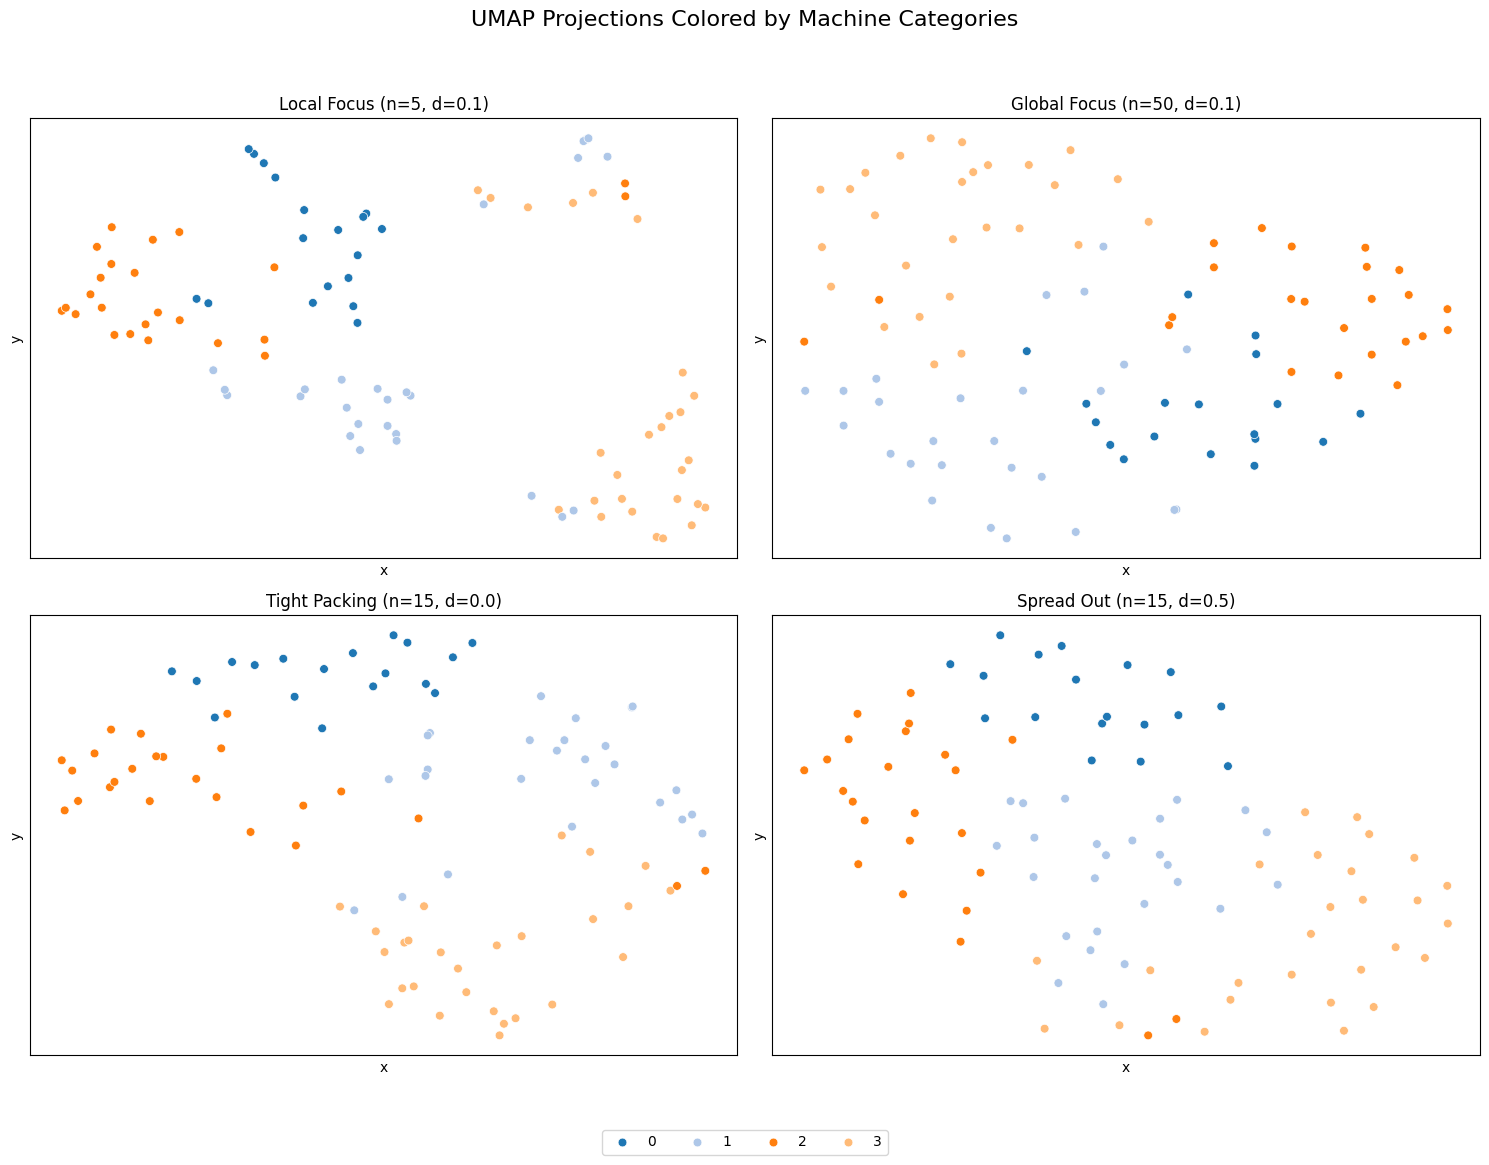

In [464]:
# If no manual categories, plot machine categories
if not RUN_MANUAL_CAT and not RUN_SUB_CAT:
    plot_umap_grid(MACHINE_CAT, "Machine Categories")

## 7. Machine vs. Human Clustering Validation
To validate the distinctiveness of the COLOR framework, we compare the manual coding against unsupervised K-Means clustering.

**What is this step?**

Here we ask a critical question: Does the AI agree with our manual coding? We force the AI to group the ideas into clusters (K-Means) based purely on language. We then compare these robot-made clusters with the human-made categories.

**Methodological Justification**

We benchmark the manual qualitative coding against unsupervised K-Means Clustering. Using metrics such as the Silhouette Score (cluster separation) and Adjusted Mutual Information (AMI), we quantify the divergence between semantic topics (Machine) and normative constructs (Human).

**Reference:** Rousseeuw, P. J. (1987). Silhouettes: A graphical aid to the interpretation and validation of cluster analysis. *Journal of Computational and Applied Mathematics*, 20, 53-65. https://doi.org/10.1016/0377-0427(87)90125-7

In [465]:
def compare_clusters(n_clusters, manual_col, title):
    # K-Means Clustering
    labels_pred = kmeans_machine_labels(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)

    # Metrics
    labels_true = df[manual_col]
    sil_machine = silhouette_score(embeddings, labels_pred, metric='cosine')
    sil_human = silhouette_score(embeddings, labels_true, metric='cosine')
    homogeneity = homogeneity_score(labels_true, labels_pred)
    completeness = completeness_score(labels_true, labels_pred)
    ami = adjusted_mutual_info_score(labels_true, labels_pred)

    print(f"--- {title} Metrics ---")
    print(f"Machine (K-Means) Silhouette: {sil_machine:.4f}")
    print(f"Human (Manual) Silhouette:    {sil_human:.4f}")
    print(f"Homogeneity:                  {homogeneity:.4f}")
    print(f"Completeness:                 {completeness:.4f}")
    print(f"Adjusted Mutual Info (AMI):   {ami:.4f}")
    print("-"*30)

    df[f"labels_pred_n{n_clusters}"] = labels_pred
    plot_umap_grid(f"labels_pred_n{n_clusters}", f'UMAP Colored by K-Means Clusters (k={n_clusters})')

In [466]:
# Compare Sub-Criteria (K=16)
if RUN_SUB_CAT:
    compare_clusters(n_clusters=16, manual_col=SUBCRITERIA_COL, title="Sub-Criteria (K=16)")

In [467]:
# Compare Main Criteria (K=4)
if RUN_MANUAL_CAT:
    compare_clusters(n_clusters=4, manual_col=CRITERIA_COL, title="Main Criteria (K=4)")

## 8. Centroid Similarity Analysis
This heatmap analysis reveals the "Conceptual Distance" between your criteria.
*   **Yellow/Green:** High semantic overlap (vocabulary is similar).
*   **Purple/Blue:** Low overlap (concepts are distinct).

**What is this step?**

This step measures the "Conceptual Distance" between your categories. It asks: Are these two groups actually different?

*   High Similarity (Yellow/Green): The groups talk about the same things using the same words (e.g., "Wages" and "Salaries").
*   Low Similarity (Purple/Blue): The groups are conceptually distinct (e.g., "Pollution" vs. "Governance"). This proves your categories aren't repetitive.

**Methodological Justification**

To quantify the distinctness of the identified clusters, we compute the Cosine Similarity between their centroids (mean vectors). By analyzing the orthogonality of these centroids in vector space, we can mathematically validate the discriminant validity of the taxonomy. High cosine similarity (≈1.0) suggests redundancy between categories, while lower scores indicate that the categories occupy distinct semantic niches.

**Reference:** Salton, G., Wong, A., & Yang, C. S. (1975). A vector space model for automatic indexing. *Communications of the ACM*, 18(11), 613-620. https://doi.org/10.1145/361219.361220

In [468]:
def plot_centroid_heatmap(label_col, title):
    unique_labels = sorted(df[label_col].dropna().unique())
    centroids = []

    for label in unique_labels:
        indices = df[df[label_col] == label].index
        group_vectors = embeddings[indices]
        centroid = np.mean(group_vectors, axis=0)
        centroids.append(centroid)

    sim_matrix = cosine_similarity(np.array(centroids))

    plt.figure(figsize=(12, 10))
    sns.heatmap(sim_matrix, xticklabels=unique_labels, yticklabels=unique_labels, cmap='viridis', annot=False)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [469]:
# Sub-Criteria Centroids
if RUN_SUB_CAT:
    plot_centroid_heatmap(SUBCRITERIA_COL, "Cosine Similarity between Sub-Criteria Centroids")

In [470]:
# Main Criteria Centroids
if RUN_MANUAL_CAT:
    plot_centroid_heatmap(CRITERIA_COL, "Cosine Similarity between Main Criteria Centroids")

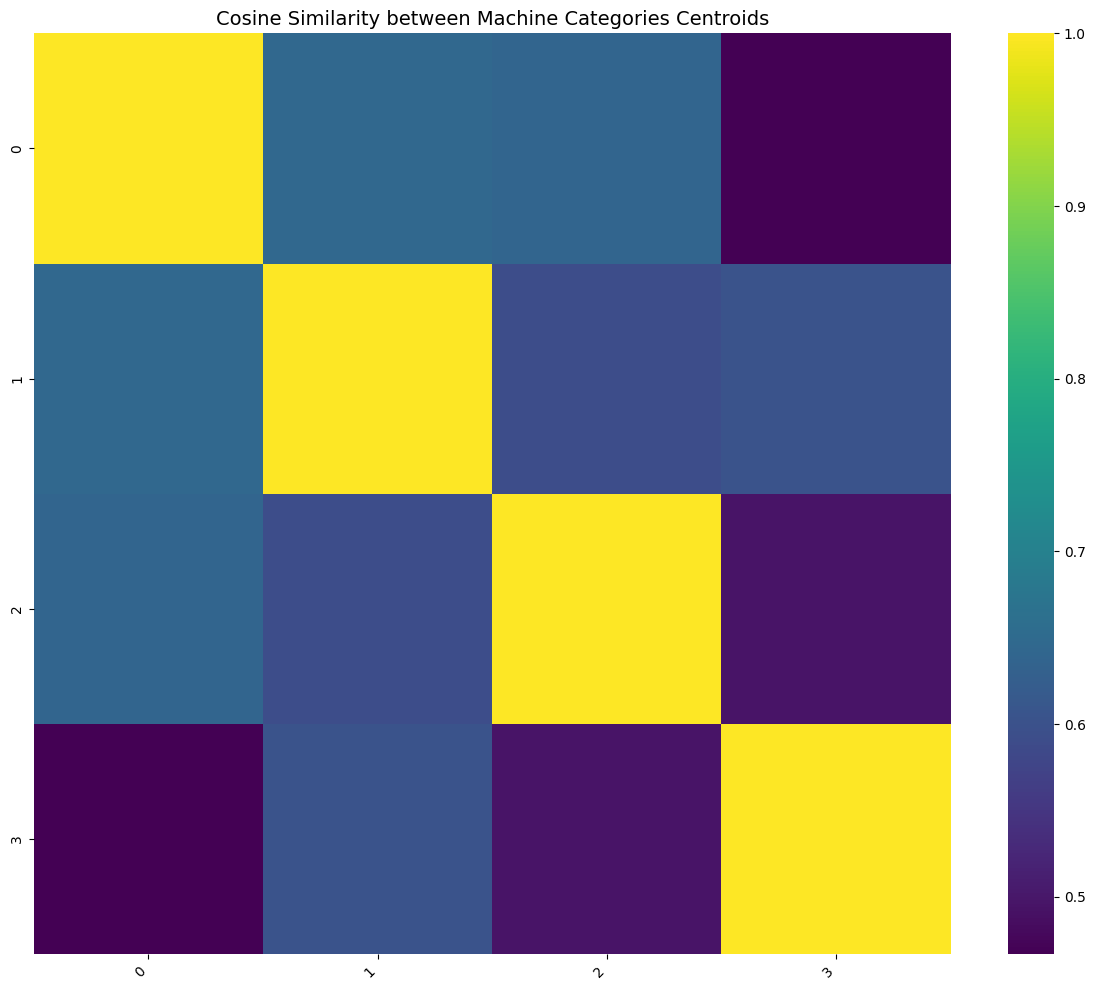

In [471]:
# If no manual categories, plot machine categories
if not RUN_MANUAL_CAT and not RUN_SUB_CAT:
    plot_centroid_heatmap(MACHINE_CAT, "Cosine Similarity between Machine Categories Centroids")

## 9. Keyword Co-occurrence Network (Louvain Community Detection)
This analysis maps the semantic backbone of the dataset.
*   **Nodes:** Lemmatized keywords.
*   **Edges:** Co-occurrence frequency (only if they appear together $\ge 3$ times).
*   **Colors:** Semantic communities detected by the Louvain algorithm.


**What is this step?**
This creates a "Brain Map" of the dataset. It draws connections between words that frequently appear together (e.g., "Water" often appears with "Pollution"). By analyzing this web, we can find the concepts that tie everything together.

**Methodological Justification**
We construct a graph network where nodes represent lemmatized keywords and edges represent co-occurrence frequency (threshold $\ge 3$). To identify latent thematic structures, we apply the Louvain Community Detection algorithm, which maximizes the modularity of the graph. This reveals the "semantic backbone" of the stakeholder discourse, identifying bridging concepts that link disparate operational domains.

Reference: Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. *Journal of Statistical Mechanics: Theory and Experiment*, 2008(10), P10008. https://doi.org/10.48550/arXiv.0803.0476

In [472]:
def keyword_cooccurance_network(normalized_text, threshold, stop_words, random_state=RANDOM_STATE):

    cv = CountVectorizer(ngram_range=(1,1), min_df=5, stop_words=stop_words)
    X_cv = cv.fit_transform(normalized_text)
    terms = cv.get_feature_names_out()

    # Compute Co-occurrence Matrix
    cooc = (X_cv.T @ X_cv).toarray()
    np.fill_diagonal(cooc, 0)

    G = nx.Graph()

    for i in range(len(terms)):
        for j in range(i+1, len(terms)):
            w = cooc[i, j]
            if w >= threshold:
                G.add_edge(terms[i], terms[j], weight=int(w))

    if len(G.nodes) > 0:
        # Louvain Detection
        partition = community_louvain.best_partition(G, random_state=random_state)

        plt.figure(figsize=(18, 14))
        pos = nx.spring_layout(G, k=0.15, seed=random_state)

        node_sizes = [v * 50 for v in dict(G.degree()).values()]
        node_colors = [partition.get(node) for node in G.nodes()]

        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Pastel2_r, alpha=0.9)
        nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')
        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif', font_weight='light')

        plt.title('Keyword Co-occurrence Network (Louvain Communities)', fontsize=16)
    plt.axis('off')
    plt.show()

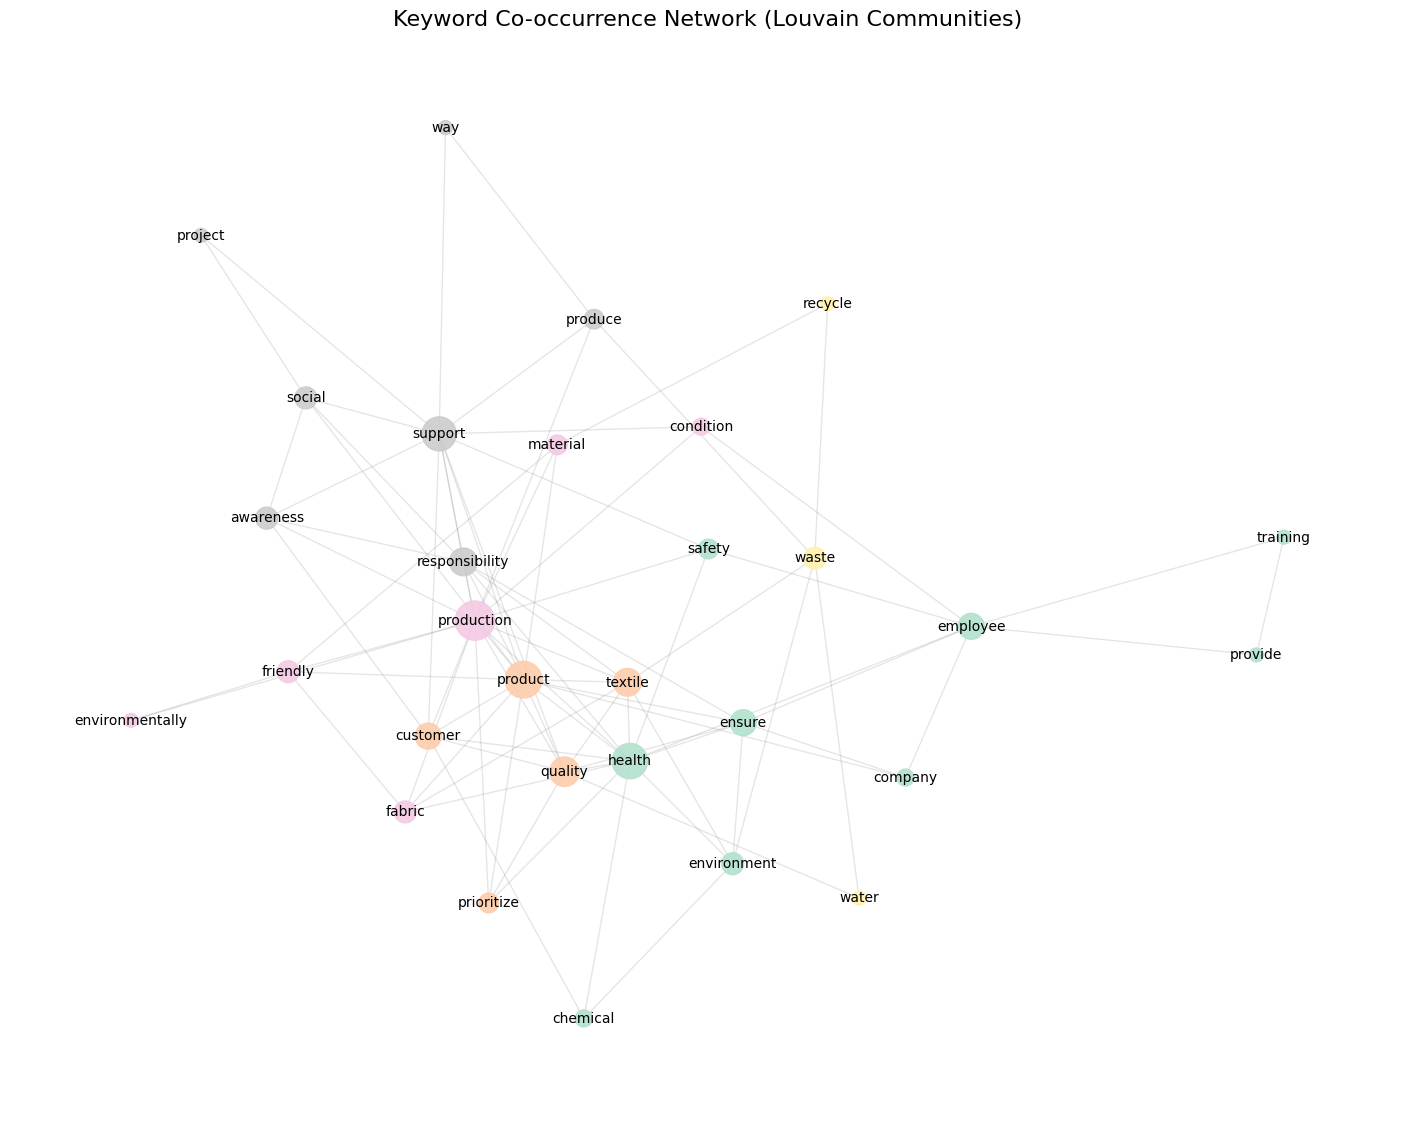

In [473]:
custom_stops = list(ENGLISH_STOP_WORDS)

keyword_cooccurance_network(df['normalized_text'], threshold=3, stop_words=custom_stops, random_state=RANDOM_STATE)

## 10. Distinctive Keyword Extraction (c-TF-IDF)
This analysis identifies the "signature" keywords for each category.
It uses **Class-based TF-IDF**, which scores words based on how unique they are to a specific cluster relative to the rest of the dataset.

**What is this step?**

Simple frequency counts are often misleading because everyone uses generic words like "company" or "textile." This step identifies the "Signature Keywords"—the words that make a specific group unique. It tells us not just what is being said, but what distinguishes Group A from Group B.

**Methodological Justification**

We employ Class-based TF-IDF (c-TF-IDF) to extract representative features for each cluster. Unlike standard TF-IDF which treats documents individually, c-TF-IDF aggregates all documents within a cluster into a single representation. It scores terms based on their frequency within the specific cluster relative to their ubiquity across the entire corpus, thereby filtering out generic stopwords and isolating the lexicon specific to each semantic category.

**Reference:** Grootendorst, M. (2022). BERTopic: Neural topic modeling with a class-based TF-IDF procedure. arXiv preprint https://doi.org/10.48550/arXiv.2203.05794.


In [474]:
def extract_ctfidf(df, label_col, text_col, n_keywords=10):

    grouped = df.groupby(label_col)[text_col].apply(lambda x: ' '.join(x)).reset_index()

    # max_df=0.7 means "ignore words that appear in more than 70% of categories" (removes generic stopwords)
    tfidf = CountVectorizer(stop_words=custom_stops, max_df=0.7)
    X = tfidf.fit_transform(grouped[text_col])
    feature_names = np.array(tfidf.get_feature_names_out())

    results = []
    dense = X.todense()

    for row_idx, row in enumerate(dense):
        category = grouped.iloc[row_idx][label_col]
        top_indices = np.asarray(row).argsort().flatten()[::-1][:n_keywords]

        top_words = feature_names[top_indices]
        top_scores = np.asarray(row).flatten()[top_indices]
        keywords_str = ", ".join([f"{word} ({score})" for word, score in zip(top_words, top_scores)])

        results.append({
            "Category": category,
            "Distinctive Keywords (Frequency Score)": keywords_str
        })

    return pd.DataFrame(results)

In [475]:
if RUN_MANUAL_CAT:
    df_keywords_main = extract_ctfidf(df.dropna(), CRITERIA_COL, 'normalized_text', n_keywords=10)

    print("\n=== Distinctive Keywords for Main Criteria ===")
    display(df_keywords_main)
    write_results_to_sheets(spreadsheet_id=spreadsheet_id, processed_data=df_keywords_main, new_worksheet_name="df_keywords_main")

In [476]:
if RUN_SUB_CAT:
    df_keywords_sub = extract_ctfidf(df.dropna(), SUBCRITERIA_COL, 'normalized_text', n_keywords=10)

    print("\n=== Distinctive Keywords for Sub-Criteria ===")
    display(df_keywords_sub)
    write_results_to_sheets(spreadsheet_id=spreadsheet_id, processed_data=df_keywords_sub, new_worksheet_name="df_keywords_sub")

In [477]:
# If no manual categories, plot machine categories
if not RUN_MANUAL_CAT and not RUN_SUB_CAT:
    df_keywords_mac = extract_ctfidf(df.dropna(), MACHINE_CAT, 'normalized_text', n_keywords=10)

    print("\n=== Distinctive Keywords for Machine Categories ===")
    display(df_keywords_mac)
    write_results_to_sheets(spreadsheet_id=spreadsheet_id, processed_data=df_keywords_mac, new_worksheet_name="df_keywords_mac")


=== Distinctive Keywords for Machine Categories ===


,Category,Distinctive Keywords (Frequency Score)
0,0,"textile (9), fabric (6), care (3), fashion (3)..."
1,1,"brand (6), consider (3), value (3), standard (..."
2,2,"waste (9), recycle (5), water (5), environment..."
3,3,"training (5), safety (5), social (4), stakehol..."


Successfully wrote results to new worksheet: df_keywords_mac


## 11. Advanced Topic Modeling with BERTopic

**What is this step?**

This tool automatically reads the text and summarizes the main conversations happening in the data (e.g., "Topic 1: Wages," "Topic 2: Recycling"). This gives us a second, data-driven perspective on what participants are talking about.

**Methodological Justification**

We employ BERTopic, a dynamic topic modeling technique that leverages class-based TF-IDF (c-TF-IDF). Unlike LDA (Latent Dirichlet Allocation), which assumes a bag-of-words document structure, BERTopic utilizes the pre-trained semantic embeddings to form dense clusters and extracts coherent topic representations that preserve contextual meaning.

**Reference:** Grootendorst, M. (2022). BERTopic: Neural topic modeling with a class-based TF-IDF procedure. arXiv preprint https://doi.org/10.48550/arXiv.2203.05794.


In [478]:
topic_model, topics, probs = bertopic_modeling(clean_text_list=df['clean_text'].tolist(),
                                                embeddings_bm=embeddings,
                                                model_bm=model,
                                                topic_size=7
                                                )
print("✅ Completed")

2025-12-21 00:18:31,125 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-21 00:18:31,315 - BERTopic - Dimensionality - Completed ✓
2025-12-21 00:18:31,317 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-21 00:18:31,328 - BERTopic - Cluster - Completed ✓
2025-12-21 00:18:31,333 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-21 00:18:32,362 - BERTopic - Representation - Completed ✓


✅ Completed


In [479]:
freq = topic_model.get_topic_info()
print(f"✅ Found {len(freq) - 1} semantic topics.") # -1 excludes the outlier topic (-1)
display(freq.head(10))

✅ Found 4 semantic topics.


,Topic,Count,Name,Representation,Representative_Docs
0,-1,16,-1_chemicals_environmentally_ensuring_detergents,"[chemicals, environmentally, ensuring, deterge...",[collaboration with civil society organization...
1,0,26,0_enviorment_harmful_production_consumers,"[enviorment, harmful, production, consumers, p...",[quality and loongevity of the products should...
2,1,22,1_employees_compliance_workplace_safety,"[employees, compliance, workplace, safety, emp...",[measures must be taken to ensure the health a...
3,2,16,2_quality_prevent_policies_ensures,"[quality, prevent, policies, ensures, producti...",[natural resources should be protected and uti...
4,3,15,3_textile_waste_luxury_products,"[textile, waste, luxury, products, eco, produc...",[to be innovative new generation fabrics shoul...


In [480]:
if len(freq) > 2: # Check if there are more than 2 topics for meaningful visualization
    fig_topics = topic_model.visualize_topics()
    # fig_topics = topic_model.visualize_topics(topics=[-1,0,1,2,3,4])
    fig_topics.show()
else:
    print("Not enough topics to visualize interdistance map effectively (found 2 or fewer topics). Change the topic_size parameter in bertopic_modeling")

In [481]:
print("=== Topic Hierarchy ===") # Shows how topics merge together
fig_hierarchy = topic_model.visualize_hierarchy()
fig_hierarchy.show()

=== Topic Hierarchy ===


## 12. Efficient Few-Shot Classification (SetFit)

**What is this step?**

We train a "Digital Assistant" to learn your specific categorization logic. Using SetFit, we only need to show the AI about 8 examples per category. It uses these few examples to learn the difference between subtle concepts (like "Internal Ethics" vs. "External Reputation") much faster and more accurately than older methods that required thousands of examples.

**Methodological Justification**

To operationalize the coding scheme with minimal labeled data, we utilize SetFit (Sentence Transformer Fine-tuning). This approach employs Contrastive Learning on a pre-trained Sentence Transformer model. By generating positive and negative triplets from a small support set (n≈8 per class), the model fine-tunes its embedding space to maximize inter-class distance and minimize intra-class distance. This yields state-of-the-art performance for few-shot text classification tasks without the computational cost of Large Language Models (LLMs).

**Reference:** Tunstall, L., et al. (2022). Efficient Few-Shot Learning Without Prompts. arXiv preprint https://doi.org/10.48550/arXiv.2209.11055.

In [482]:
SAMPLES_PER_CLASS = 8
def few_shot_classification(COL_NAME, random_state=RANDOM_STATE):
    train_df = df.groupby(COL_NAME).apply(lambda x: x.sample(n=min(len(x), SAMPLES_PER_CLASS), random_state=random_state)).reset_index(drop=True)
    test_df = df.drop(train_df.index)

    # Convert to HuggingFace Dataset format
    # SetFit requires columns named 'text' and 'label'
    train_ds = Dataset.from_pandas(train_df[[translate_column, COL_NAME]].rename(columns={translate_column: "text", COL_NAME: "label"}))
    test_ds = Dataset.from_pandas(test_df[[translate_column, COL_NAME]].rename(columns={translate_column: "text", COL_NAME: "label"}))

    print(f"⏳ Training SetFit on just {len(train_df)} examples...")

    setfit_model_sf = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

    trainer_sf = Trainer(
        model=setfit_model_sf,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        metric="accuracy"
    )

    trainer_sf.train()
    print("✅ Training Complete.")
    return trainer_sf, setfit_model_sf, test_ds

In [483]:
def few_shot_visualization(setfit_model, test_ds):
    preds = setfit_model.predict(test_ds["text"])

    # Create the Confusion Matrix
    cm = confusion_matrix(test_ds["label"], preds, labels=test_ds.unique("label"))
    labels = test_ds.unique("label")

    # Plotting
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    plt.title('Confusion Matrix: Where did the model get confused?', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [484]:
if RUN_MANUAL_CAT:
  os.environ["WANDB_DISABLED"] = "true"
  trainer_cr, setfit_model_cr, test_cr = few_shot_classification(CRITERIA_COL, random_state=RANDOM_STATE)
  print("⏳ Evaluating on unseen test data...")
  metrics_cr = trainer_cr.evaluate()
  print(f"Accuracy: {metrics_cr['accuracy']:.4f}")

  few_shot_visualization(setfit_model_cr, test_cr)

In [485]:
if RUN_SUB_CAT:
  os.environ["WANDB_DISABLED"] = "true"
  trainer_sc, setfit_model_sc, test_sc  = few_shot_classification(SUBCRITERIA_COL, random_state=RANDOM_STATE)
  print("⏳ Evaluating on unseen test data...")
  metrics_sc = trainer_sc.evaluate()
  print(f"Accuracy: {metrics_sc['accuracy']:.4f}")

  few_shot_visualization(setfit_model_sc, test_sc)